In [1]:
import sys
import os
sys.path.append(os.path.abspath('../src')) # include top level package in python path

In [2]:
from IPython.display import display, HTML
display(HTML("""
<style>
.container { 
    width: 100% !important;
}
</style>
"""))

In [3]:
import torch
from torch import nn, Tensor
from model.fuzzy_layer import FuzzyUnsignedConjunction, FuzzyUnsignedDisjunction, FuzzyNumKeepup, keepidx, fuzzy_dropup
from model.fuzzy_logic import ProductLogic, MinimumLogic, LukasiewiczLogic, DrasticLogic, SchweizerSklarLogic
from model.fuzzy_layer import FuzzyParam
from model.bool_logic import BoolLogic
from cache import TrainingRegime, TestMetric
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from util import shuffle

logic = BoolLogic()
flogic = ProductLogic()

In [4]:
device = 'cuda'

In [5]:
def true_conjunction(weights, xs):
    return logic.conjoin(logic.implies(weights, xs), dim=1)

In [6]:
from torch.utils.data import Dataset, DataLoader, RandomSampler

class WeightedDataset(Dataset):
    def __init__(self, N, D, K):
        super().__init__()
        self.samples = torch.zeros((N, D), dtype=torch.bool)
        self.samples[:,:K] = True
        self.samples = shuffle(self.samples, dim=-1)
        
    def __len__(self):
        return self.samples.size(0)
        
    def __getitem__(self, idx):
        return self.samples[idx]

class BinaryDataset(Dataset):
    def __init__(self, shape, N):
        self.samples = torch.distributions.bernoulli.Bernoulli(
            0.5
        ).sample(
            torch.Size([N, *shape])
        ).bool()
        
    def __len__(self):
        return self.samples.size(0)
    
    def __getitem__(self, idx):
        return self.samples[idx]

In [7]:
class CorrectParamMetric(TestMetric):
    def __init__(self, ideal_params):
        self.ideal_params = ideal_params
    
    def name(self):
        return "correct-param"

    def measure_model(self, model, _):
        params = (model.weights.value() > 0.5).flatten()
        no_correct = (self.ideal_params == params).sum()
        return (no_correct / params.numel()).item()
    
class ParamMeanDistanceMetric(TestMetric):
    def __init__(self, ideal_params):
        self.ideal_params = ideal_params
        
    def name(self):
        return "param-mean-distance"
    
    def measure_model(self, model, _):
        params = model.weights.value().flatten()
        crispness = (params - self.ideal_params.float()).abs().mean()
        return crispness.item()
    
class ParamMaxDistanceMetric(TestMetric):
    def __init__(self, ideal_params):
        self.ideal_params = ideal_params
        
    def name(self):
        return "param-max-distance"
    
    def measure_model(self, model, _):
        params = model.weights.value().flatten()
        crispness = (params - self.ideal_params.float()).abs().max()
        return crispness.item()
    
class CorrectOutputMetric(TestMetric):
    def __init__(self, ideal_params):
        self.ideal_params = ideal_params
        
    def name(self):
        return "correct-output"
    
    def measure_model(self, model, it):
        count = 0
        correct = 0
        for bs in it():
            bs = model._logic.encode(bs.to(device))
            pred = (model(bs) > 0.5).flatten()
            true = true_conjunction(self.ideal_params, bs)
            correct += (pred == true).sum().item()
            count += bs.size(dim=0)
        return (correct / count)
    
class OutputDistanceMetric(TestMetric):
    def __init__(self, ideal_params):
        self.ideal_params = ideal_params
        
    def name(self):
        return "output-distance"
    
    def measure_model(self, model, it):
        count = 0
        correct = 0
        for bs in it():
            bs = model._logic.encode(bs.to(device))
            pred = model(bs).flatten()
            true = true_conjunction(self.ideal_params, bs)
            correct += (pred - true.float()).abs().sum().item()
            count += bs.size(dim=0)
        return (correct / count)

In [8]:
def rand_n_true(shape, N):
    falses = torch.zeros(shape, dtype=torch.bool)
    falses = falses.view(-1)
    falses[:N] = True
    falses = falses[torch.randperm(falses.size(0))]
    return falses.view(*shape)

In [9]:
class ConjunctionRegime(TrainingRegime):
    def __init__(self, logic, no_dims=1000, no_terms=5, no_runs=1, keepn=None, optim='adam', lr=1e-2):
        super().__init__("./conjunctions/", no_runs)
        
        self.flogic = logic
        self.no_dims = no_dims
        self.no_terms = no_terms
        self.keepn = keepn
        self.optim = 'adam' if optim == 'adam' else 'sgd'
        self.lr = lr
        
        self.weights = self.cache(
            "weights", 
            lambda: rand_n_true([self.no_dims], self.no_terms).to(device)
        )
        
        self.tests = [
            OutputDistanceMetric(self.weights),
            CorrectOutputMetric(self.weights),
            CorrectParamMetric(self.weights),
            ParamMeanDistanceMetric(self.weights),
            ParamMaxDistanceMetric(self.weights),
        ]
        
        self.training_dataset = BinaryDataset([self.no_dims], 10_000)
        self.testing_dataset = BinaryDataset([self.no_dims], 10_000)
        
        self.optims = [None] * no_runs
        
    def get_logic_str(self):
        if isinstance(self.flogic, ProductLogic):
            return "product"
        elif isinstance(self.flogic, MinimumLogic):
            return "minimum"
        elif isinstance(self.flogic, LukasiewiczLogic):
            return "lukasiewicz"
        elif isinstance(self.flogic, DrasticLogic):
            return "drastic"
        elif isinstance(self.flogic, SchweizerSklarLogic):
            return "schweizer-sklar"
        else:
            return "fuzzy"
        
    def get_optim(self, run_no):
        optim = self.optims[run_no - 1]
        if optim is None:
            model = self.get_loaded_model(run_no)
            optim = self.optims[run_no - 1] = (
                torch.optim.SGD(model.parameters(), lr=self.lr)
                if self.optim == "sgd"
                else torch.optim.Adam(model.parameters(), lr=self.lr)
            )
        return optim
        
    def regime_str(self):
        keep_str = "" if self.keepn is None else " | KEEP N = %s" % self.keepn
        return (
            "CONJUNCTIONS | %s, LR = %s | %s LOGIC | %s DIMENSIONS | %s TERMS%s"
            % (
                self.optim.upper(), 
                self.lr,
                self.get_logic_str().upper(), 
                self.no_dims, 
                self.no_terms, 
                keep_str
            )
        ) 
        
    def regime_filename_elems(self):
        elems = [
            "conj", 
            self.optim,
            str(self.lr),
            self.get_logic_str(),
            "%sdims" % self.no_dims,
            "%sterms" % self.no_terms
        ]
        if self.keepn is not None:
            elems.append("keep%s" % self.keepn)
        return elems
        
    def training_dataloader(self, run_no):
        return DataLoader(self.training_dataset, batch_size=128)
    
    def testing_dataloader(self, run_no):
        return DataLoader(self.testing_dataset, batch_size=128)
    
    def training_step(self, run_no, model):
        optim = self.get_optim(run_no)
        
        def step(bs):
            bs = bs.cuda()
            cjs = true_conjunction(self.weights, bs)
            cj_hats = model(self.flogic.encode(bs)).squeeze()
            loss = (self.flogic.bin_xor(self.flogic.encode(cjs), cj_hats) ** 10).sum()
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
        return step
        
    def new_model(self):
        return FuzzyUnsignedConjunction(
            in_features=self.no_dims, 
            out_features=1, 
            logic=self.flogic, 
            keepn=self.keepn
        ).to(device)

In [10]:
def defer_regime(*args, **kargs):
    def return_regime():
        return ConjunctionRegime(*args, **kargs)
    return return_regime

regimes = [
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=5, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=5, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=5, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=5, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=5, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=5, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=5, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=5, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=1, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=1, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=1, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=1, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=1, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=1, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=1, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=1, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=20, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=20, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=20, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=20, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=20, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=20, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=20, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=20, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=1, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=1, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=1, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=1, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=1, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=1, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=1, keepn=50, no_runs=5),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=1, keepn=50, no_runs=3),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=20, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=20, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=20, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=20, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=20, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=20, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=20, keepn=50, no_runs=5),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=20, keepn=50, no_runs=3),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=5, lr=1e-1),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3, lr=1e-1),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=5, lr=1e-0),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3, lr=1e-0),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=5, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=5, lr=1e-1, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3, lr=1e-1, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=5, lr=1e-0, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3, lr=1e-0, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=MinimumLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=MinimumLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=MinimumLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=MinimumLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=MinimumLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=MinimumLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=5),
    defer_regime(logic=MinimumLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3),
    defer_regime(logic=MinimumLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=MinimumLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=MinimumLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=MinimumLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=MinimumLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=MinimumLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=MinimumLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=5, lr=1e-1),
    defer_regime(logic=MinimumLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3, lr=1e-1),
    defer_regime(logic=MinimumLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=MinimumLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=MinimumLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=MinimumLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=MinimumLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=MinimumLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=MinimumLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=5, lr=1e-0),
    defer_regime(logic=MinimumLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3, lr=1e-0),
    defer_regime(logic=MinimumLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=5, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=5, lr=1e-1, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3, lr=1e-1, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=5, lr=1e-0, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=3, lr=1e-0, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=5, lr=1e-0, optim='sgd'),
    defer_regime(logic=SchweizerSklarLogic(torch.tensor(-2.0).to(device)), no_dims=10, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=SchweizerSklarLogic(torch.tensor(-2.0).to(device)), no_dims=30, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=SchweizerSklarLogic(torch.tensor(-2.0).to(device)), no_dims=50, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=SchweizerSklarLogic(torch.tensor(-2.0).to(device)), no_dims=100, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=SchweizerSklarLogic(torch.tensor(-2.0).to(device)), no_dims=300, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=SchweizerSklarLogic(torch.tensor(-2.0).to(device)), no_dims=500, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=SchweizerSklarLogic(torch.tensor(-2.0).to(device)), no_dims=1000, no_terms=5, keepn=50, no_runs=5),
    defer_regime(logic=SchweizerSklarLogic(torch.tensor(-2.0).to(device)), no_dims=10000, no_terms=5, keepn=50, no_runs=3),
    defer_regime(logic=LukasiewiczLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=LukasiewiczLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=LukasiewiczLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=LukasiewiczLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10),
]

if False:
    for regime_f in regimes:
        regime = regime_f()
        regime.load_latest_models()
        regime.load_all_results()
        for i in range(1, regime.no_runs + 1):
            regime.loop_until(i, 100)
        del regime

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2,…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2,…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2,…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3,…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3,…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3,…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4,…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4,…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4,…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5,…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5,…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5,…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6,…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6,…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6,…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7,…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7,…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7,…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8,…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8,…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8,…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9,…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9,…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9,…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #10…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #10…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #10…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #11…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #11…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #11…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #12…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #12…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #12…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #13…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #13…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #13…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #14…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #14…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #14…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #15…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #15…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #15…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #16…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #16…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #16…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #17…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #17…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #17…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #18…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #18…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #18…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #19…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #19…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #19…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #20…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #20…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #20…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #21…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #21…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #21…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #22…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #22…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #22…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #23…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #23…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #23…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #24…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #24…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #24…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #25…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #25…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #25…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #26…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #26…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #26…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #27…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #27…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #27…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #28…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #28…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #28…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #29…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #29…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #29…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #30…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #30…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #30…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #31…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #31…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #31…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #32…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #32…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #32…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #33…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #33…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #33…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #34…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #34…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #34…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #35…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #35…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #35…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #36…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #36…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #36…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #37…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #37…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #37…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #38…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #38…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #38…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #39…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #39…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #39…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #40…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #40…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #40…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #41…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #41…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #41…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #42…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #42…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #42…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #43…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #43…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #43…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #44…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #44…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #44…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #45…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #45…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #45…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #46…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #46…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #46…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #47…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #47…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #47…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #48…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #48…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #48…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #49…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #49…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #49…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #50…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #50…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #50…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #51…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #51…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #51…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #52…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #52…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #52…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #53…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #53…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #53…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #54…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #54…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #54…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #55…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #55…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #55…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #56…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #56…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #56…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #57…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #57…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #57…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #58…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #58…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #58…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #59…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #59…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #59…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #60…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #60…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #60…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #61…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #61…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #61…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #62…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #62…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #62…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #63…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #63…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #63…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #64…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #64…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #64…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #65…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #65…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #65…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #66…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #66…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #66…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #67…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #67…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #67…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #68…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #68…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #68…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #69…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #69…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #69…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #70…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #70…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #70…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #71…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #71…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #71…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #72…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #72…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #72…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #73…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #73…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #73…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #74…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #74…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #74…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #75…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #75…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #75…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #76…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #76…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #76…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #77…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #77…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #77…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #78…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #78…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #78…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #79…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #79…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #79…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #80…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #80…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #80…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #81…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #81…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #81…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #82…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #82…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #82…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #83…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #83…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #83…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #84…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #84…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #84…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #85…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #85…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #85…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #86…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #86…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #86…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #87…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #87…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #87…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #88…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #88…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #88…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #89…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #89…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #89…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #90…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #90…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #90…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #91…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #91…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #91…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #92…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #92…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #92…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #93…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #93…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #93…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #94…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #94…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #94…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #95…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #95…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #95…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #96…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #96…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #96…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #97…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #97…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #97…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #98…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #98…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #98…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #99…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #99…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #99…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #10…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #10…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #10…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 50 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #2, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #3, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #4, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #5, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #6, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #7, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #8, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #2…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #3…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #4…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #5…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #6…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #7…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #8…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #9…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #9, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | LUKASIEWICZ LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50] Run #10, Epoch #…

In [160]:
def plot_regime(regime, metric, color, ax):
    
    try:

        regime.load_latest_models()
        regime.load_all_results()

        for i in range(0, 10):
            if regime.results[i] is None:
                if i == 0:
                    return False
                break
            plt.plot(
                regime.results[i]['epoch'], 
                regime.results[i][metric],
                color=color,
                alpha=0.3
            )

        return True
    
    except:
        return False
        
def plot_regimes_over_logics(
    ax,
    metric='correct-param',
    #logic, 
    no_dims=1000, 
    no_terms=5, 
    no_runs=10, 
    keepn=50, 
    optim='adam', 
    lr=1e-2,
):
    logics = [
        ProductLogic(),
        MinimumLogic(),
        SchweizerSklarLogic(torch.tensor(-2.0).to(device)),
        LukasiewiczLogic(),
    ]
    
    logic_labels = [
        "Product Logic",
        "Minimum Logic",
        "Schweizer-Sklar Logic (b = -2.0)",
        "Lukasiewicz Logic"
    ]
    
    ax.set_xlabel("epoch")
    ax.set_ylabel(metric)
    ax.set_xlim(1,100)
    
    lines = []
    
    for idx, logic in enumerate(logics):
        regime = ConjunctionRegime(logic=logic, no_dims=no_dims, no_terms=no_terms, keepn=keepn, no_runs=no_runs, optim=optim, lr=lr)
        color = cm.Dark2(idx / ((len(logics) - 1)))
        if plot_regime(regime, metric, color, ax):
            lines.append(mpatches.Patch(color=color, label=logic_labels[idx]))
                    
    ax.legend(handles=lines)
    
    
def plot_regimes_over_ndims(
    ax,
    metric='correct-param',
    logic=ProductLogic(), 
    #no_dims=1000, 
    no_terms=5, 
    no_runs=10, 
    keepn=50, 
    optim='adam', 
    lr=1e-2,
):
    
    no_dims = [
        10, 
        #30, 
        #50, 
        100, 
        #300, 
        #500, 
        1000, 
        10000
    ]
    
    ax.set_xlabel("epoch")
    ax.set_ylabel(metric)
    ax.set_xlim(1,100)
    
    lines = []
    
    for idx, no_dim in enumerate(no_dims):
        regime = ConjunctionRegime(logic=logic, no_dims=no_dim, no_terms=no_terms, keepn=keepn, no_runs=no_runs, optim=optim, lr=lr)
        color = cm.rainbow(idx / (len(no_dims) - 1))
        if plot_regime(regime, metric, color, ax):
            lines.append(mpatches.Patch(color=color, label="N = %s" % no_dim))
                    
    ax.legend(handles=lines)
        

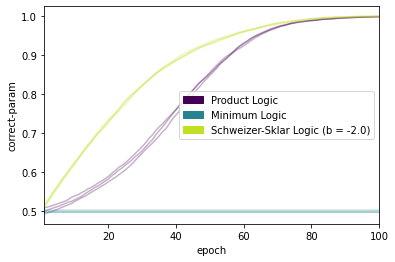

In [107]:
import matplotlib.cm as cm
import matplotlib.patches as mpatches

no_dims = [10, 30, 50, 100, 300, 500, 1000, 10000]
logics = [
    ProductLogic(),
    MinimumLogic(),
    SchweizerSklarLogic(torch.tensor(-2.0).to(device)),
    #LukasiewiczLogic(),
]
logic_labels = [
    "Product Logic",
    "Minimum Logic",
    "Schweizer-Sklar Logic (b = -2.0)",
    "Lukasiewicz Logic"
]

y_label = 'correct-param'

#for idx, no_dim in enumerate(no_dims):
#    regime = ConjunctionRegime(logic=SchweizerSklarLogic(torch.tensor(-2.0).to(device)), no_dims=no_dim, no_terms=5, keepn=50, no_runs=10)
lines = []



plt.xlabel("epoch")
plt.ylabel(y_label)
plt.xlim(1,100)
    
for idx, logic in enumerate(logics):
    regime = ConjunctionRegime(logic=logic, no_dims=10000, no_terms=5, keepn=50, no_runs=10)
    regime.load_latest_models()
    regime.load_all_results()
    color = cm.viridis(idx / (1.1*(len(logics) - 1)))
    color = cm.gnuplot2(idx / (len(no_dims) - 1))
    
    lines.append(mpatches.Patch(color=color, label=logic_labels[idx]))
    for i in range(0, 10):
        if regime.results[i] is None:
            break
        plt.plot(
            regime.results[i]['epoch'], 
            regime.results[i][y_label],
            color=color,
            alpha=0.3
        )
        

plt.legend(handles=lines)

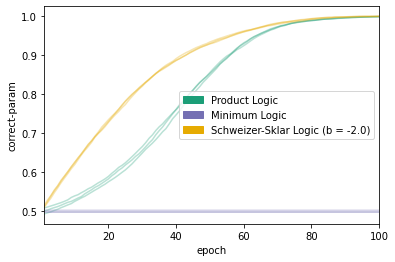

In [163]:
fig, ax = plt.subplots()

plot_regimes_over_logics(ax, no_dims=10000)

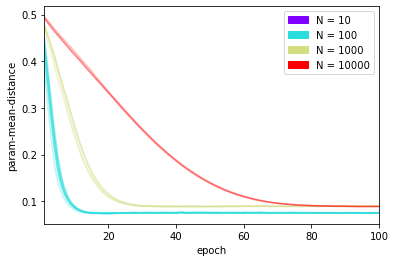

In [162]:
fig, ax = plt.subplots()

plot_regimes_over_ndims(ax, metric='param-mean-distance', logic=SchweizerSklarLogic(torch.tensor(-2.0).to(device)))

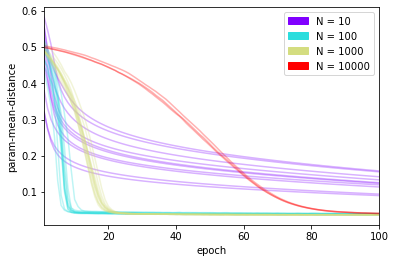

In [164]:
fig, ax = plt.subplots()

plot_regimes_over_ndims(ax, metric='param-mean-distance', logic=ProductLogic())

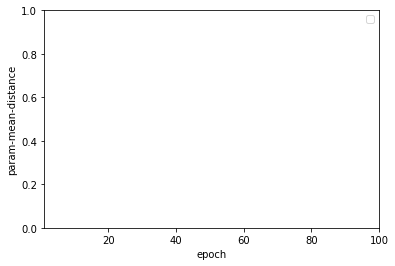

In [166]:
fig, ax = plt.subplots()

plot_regimes_over_ndims(ax, metric='param-mean-distance', logic=ProductLogic(), optim='sgd')

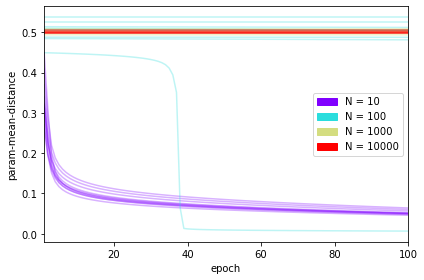

In [170]:
fig, ax = plt.subplots()

plot_regimes_over_ndims(ax, metric='param-mean-distance', logic=ProductLogic(), keepn=None, no_terms=1)
fig.tight_layout()

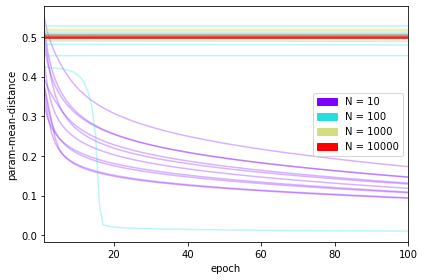

In [171]:
fig, ax = plt.subplots()

plot_regimes_over_ndims(ax, metric='param-mean-distance', logic=ProductLogic(), keepn=None, no_terms=5)

fig.tight_layout()

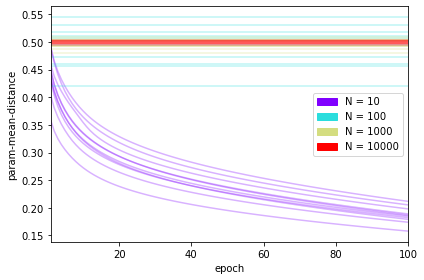

In [172]:
fig, ax = plt.subplots()

plot_regimes_over_ndims(ax, metric='param-mean-distance', logic=ProductLogic(), keepn=None, no_terms=20)

fig.tight_layout()